# The California housing problem

The goal is to predict the median house value on a series of California districts.

Read info on the problem and download csv file from https://www.kaggle.com/camnugent/california-housing-prices.

### Instrucciones de entrega

#### Seguid cuidadosamente las siguientes pautas

1. Crear un directorio de nombre vuestro apellido.
2. Situar en él 
    * Un archivo `apellido_afi_2018.ipynb` con vuestro notebook completo y otro archivo `apellido_afi_2018.html` con una versión html
    * Un archivo `cal_housing.csv` con los datos del problema.
    * Un archivo `'mlp_alpha_search_results.pkl` con los resultados de GridSearchCV para vuestro MLP.
    * Un archivo `'svr_C_gamma_epsilon_cv_search_results.pkl` con los resultados de GridSearchCV para vuestra SVR.
3. Situar también en él un archivo word `apellido.docx`  o pdf `apellido.pdf` con las respuestas al cuestionario.
4. Comprimir el **directorio** a un archivo `apellido.zip` o `apellido.7z` que será lo que se entregue

Para cualquier duda,consultar con el profesor (jose.dorronsoro@uam.es) 

In [237]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [238]:
#Importamos todas las librerías que vamos a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import time
import pickle
import gzip

import sklearn as skl
import seaborn as sns

## Data Preprocessing

**_After loading data apply the following steps_**

* Check data counts and remove possible missing values using Pandas' `dropna` method.
* Ignore the longitude and latitude variables and also the categorical variable `ocean_proximity`.
* Analyze the original variables and consider new variables which could be more informative.
* Analyze feature distributions and adequately remove possible outliers.

In [239]:
#Cargamos el dataset

f = 'cal_housing.csv'

df_housing_raw = pd.read_csv(f)

print ("n_rows: %d\tn_columns: %d\n" % (df_housing_raw.shape[0], df_housing_raw.shape[1]) )
print ("columns:\t", list(df_housing_raw.columns))

n_rows: 20640	n_columns: 10

columns:	 ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity']


In [240]:
df_housing_raw.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


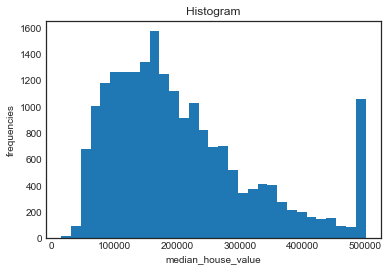

In [241]:
#Observamos com se distribuyen los precios medios
plt.title("Histogram")
plt.xlabel("median_house_value")
plt.ylabel("frequencies")
_ = plt.hist(df_housing_raw.median_house_value, bins=31)

**_Check the data counts and if needed, remove the records with possibly missing values.
You can use the dropna method in pandas for this._**

Working variables:

For simplicity we will not consider the longitude and latitude variables. We will also ignore the categoric variable `ocean_proximity`although it might encode useful house value information.

In [242]:
#Eliminamos las variables siguientes por simplicidad:

df_housing_raw = df_housing_raw.drop(['longitude', 'latitude', 'ocean_proximity'],axis=1)

#Observamos que los NAs
print (np.isnan(df_housing_raw).sum())
print( "\t")

#Tenemos 207 nan en la variable 'total_bedrooms'.  Supone un 1% del dataset por lo que procedemos a eliminarlos.

df_housing_raw = df_housing_raw.dropna()
print (np.isnan(df_housing_raw).sum())


housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
dtype: int64
	
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
dtype: int64


In [243]:
#Definimos cuales van a ser nuestras features y nuestro target
vars     = ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
target   = ['median_house_value']

**_The initial variables may not be too useful as some of them (e.g., `total_rooms`) represent total values over a district. It seems thus sensible to use as new (or extra) variables their averages per household._**

**_Decide which variables should be thus treated and which shouldn't, compute the new variables you think useful_**

**_Explain HERE clearly why you choose the new variables_**

Vamos a comenzar con un proceso de **feature engineering** para crear nuevas variables que hagan funcionar mejor nuestro algoritmo de machine learning. En primer lugar crearemos la variable *median_rooms_perhouse* que indicará el número medio de habitaciones que hay por cada casa. De igual manera con *median_bedrooms_perhouse* con el número medio de dormitorios por casa y por último, *media_person_perhouse* que nos indicará el número medio de habitantes por domicilio.

In [244]:
df_housing = df_housing_raw
df_housing['median_rooms_perhouse'] = df_housing_raw['total_rooms']/df_housing_raw['households']
df_housing['median_bedrooms_perhouse'] = df_housing_raw['total_bedrooms']/df_housing_raw['households']
df_housing['median_person_perhouse'] = df_housing_raw['population']/df_housing_raw['households'] 

In [245]:
df_housing.columns

Index(['housing_median_age', 'total_rooms', 'total_bedrooms', 'population',
       'households', 'median_income', 'median_house_value',
       'median_rooms_perhouse', 'median_bedrooms_perhouse',
       'median_person_perhouse'],
      dtype='object')

**_Analyze the new data looking for extreme values and, finally, drop those patterns for which some of these variables may have values that you think unlikely._**

**_Explain HERE clearly which values you consider too high and how you are to what transform the initial data_**

In [246]:
df_housing.describe().T

,count,mean,std,min,25%,50%,75%,max
housing_median_age,20433.0,28.633094,12.591805,1.000000,18.000000,29.000000,37.000000,52.000000
total_rooms,20433.0,2636.504233,2185.269567,2.000000,1450.000000,2127.000000,3143.000000,39320.000000
total_bedrooms,20433.0,537.870553,421.385070,1.000000,296.000000,435.000000,647.000000,6445.000000
population,20433.0,1424.946949,1133.208490,3.000000,787.000000,1166.000000,1722.000000,35682.000000
households,20433.0,499.433465,382.299226,1.000000,280.000000,409.000000,604.000000,6082.000000
median_income,20433.0,3.871162,1.899291,0.499900,2.563700,3.536500,4.744000,15.000100
median_house_value,20433.0,206864.413155,115435.667099,14999.000000,119500.000000,179700.000000,264700.000000,500001.000000
median_rooms_perhouse,20433.0,5.431344,2.482946,0.846154,4.441441,5.230769,6.052381,141.909091
median_bedrooms_perhouse,20433.0,1.097062,0.476104,0.333333,1.006029,1.048889,1.099631,34.066667
median_person_perhouse,20433.0,3.071533,10.438269,0.692308,2.429032,2.817582,3.281513,1243.333333


Realizamos un análisis descriptivo de los datos para ver posibles outliers o datos anómalos. Observamos que estos aparecen en las nuevas variables que hemos creado por lo que vamos a dibujarnos los histogramas para obtener más información:

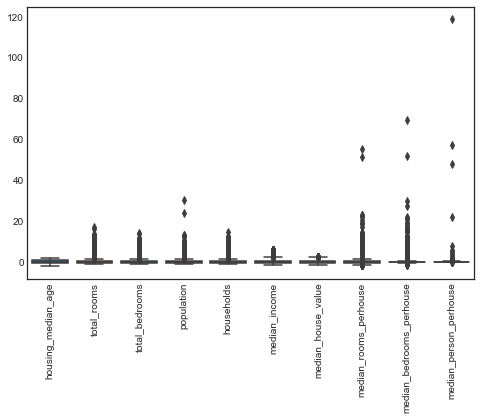

In [247]:
#normalizamos para tener rangos uniformes en histogramas
df_housing_normalizado = (df_housing - df_housing.mean()) / df_housing.std() 

plt.figure( figsize=(8, 5))
sns.set_style("white")
bx_plot = sns.boxplot(data=df_housing_normalizado)
#bx_plot = sns.boxplot(data=df_housing)
plt.xticks(rotation=90)
plt.show()

Observamos valores extremos en las últimas tres variables. Vamos a analizarlos.

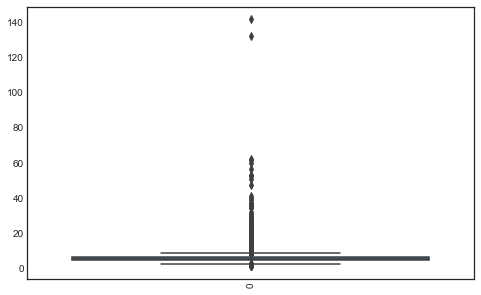

In [248]:
# median rooms per house
plt.figure( figsize=(8, 5))
sns.set_style("white")
bx_plot = sns.boxplot(data=df_housing.median_rooms_perhouse)
plt.xticks(rotation=90)
plt.show()

Hay viviendas con más de 20 habitaciones por vivienda llegando incluso a las 140 lo cual es bastante anómalo. Decidimos eliminar estas observaciones.

In [249]:
# median rooms per house. Eliminamos aquellas observaciones con más de 20 habitaciones (69)
print('Número de viviendas con más de 20 habitaciones:\t',(df_housing.median_rooms_perhouse > 20).sum())
df_housing = df_housing[df_housing['median_rooms_perhouse']<20]

Número de viviendas con más de 20 habitaciones:	 69


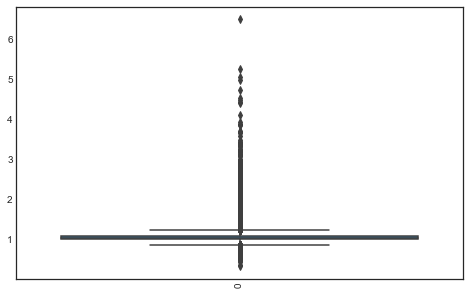

In [250]:
# median bedrooms per house
plt.figure( figsize=(8, 5))
sns.set_style("white")
bx_plot = sns.boxplot(data=df_housing.median_bedrooms_perhouse)
plt.xticks(rotation=90)
plt.show()

In [251]:
# median bedrooms per house
print('Número de viviendas con más de 5 dormitorios:\t',(df_housing.median_bedrooms_perhouse > 6).sum())

#Mantenemos estos valores porque si tiene sentido casas con más de 5 habitaciones

Número de viviendas con más de 5 dormitorios:	 1


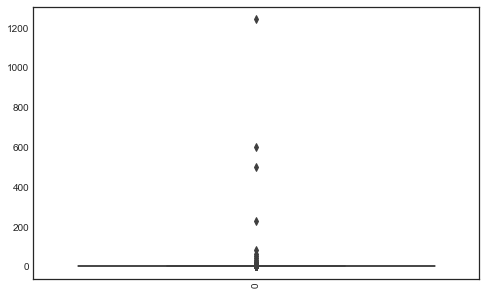

In [252]:
# median population per house
plt.figure( figsize=(8, 5))
sns.set_style("white")
bx_plot = sns.boxplot(data=df_housing.median_person_perhouse)
plt.xticks(rotation=90)
plt.show()

En cuanto al número de habitantes por cada casa, nos encontramos 10 viviendas con más de 20 habitantes. Dichas observaciones vamos a proceder a eliminarlas.

In [253]:
# median person per house. Encontramos outliers, eliminamos aquellas observaciones en las que hay más de 20 habitantes en cada casa

print((df_housing.median_person_perhouse > 20).sum())
df_housing = df_housing[df_housing['median_person_perhouse']<20]

10


**_After these operations have been done, write HERE a descriptive analysis of your data, considering whether you could drop some features to alleviate computational costs. 

Finalmente nos hemos quedado con las siguientes variables: 'housing_median_age', 'households', 'median_income','median_house_value', 'median_rooms_perhouse','median_bedrooms_perhouse' y 'median_person_perhouse', es decir, 7 variables de las cuales una es el target.

In [254]:
print (df_housing.columns)
df_housing.shape


Index(['housing_median_age', 'total_rooms', 'total_bedrooms', 'population',
       'households', 'median_income', 'median_house_value',
       'median_rooms_perhouse', 'median_bedrooms_perhouse',
       'median_person_perhouse'],
      dtype='object')


(20354, 10)

Finalmente nuestro dataset cuenta con 20354 observaciones y 7 variables. Vamos a estudiar las correlaciones para ver si existe multicolinealidad y podemos eliminar alguna variable de cara al posterior análisis.

## Correlation Analysis

In [255]:
# correlation heatmap
df_housing.corr().round(decimals=3)

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,median_rooms_perhouse,median_bedrooms_perhouse,median_person_perhouse
housing_median_age,1.000,-0.362,-0.321,-0.302,-0.307,-0.119,0.106,-0.221,-0.123,-0.008
total_rooms,-0.362,1.000,0.930,0.865,0.923,0.199,0.134,0.220,0.058,-0.109
total_bedrooms,-0.321,0.930,1.000,0.886,0.984,-0.007,0.050,-0.007,0.099,-0.143
population,-0.302,0.865,0.886,1.000,0.911,0.003,-0.026,-0.056,-0.056,0.169
households,-0.307,0.923,0.984,0.911,1.000,0.013,0.064,-0.069,-0.028,-0.128
median_income,-0.119,0.199,-0.007,0.003,0.013,1.000,0.690,0.584,-0.123,-0.063
median_house_value,0.106,0.134,0.050,-0.026,0.064,0.690,1.000,0.274,-0.089,-0.241
median_rooms_perhouse,-0.221,0.220,-0.007,-0.056,-0.069,0.584,0.274,1.000,0.491,-0.052
median_bedrooms_perhouse,-0.123,0.058,0.099,-0.056,-0.028,-0.123,-0.089,0.491,1.000,-0.082
median_person_perhouse,-0.008,-0.109,-0.143,0.169,-0.128,-0.063,-0.241,-0.052,-0.082,1.000


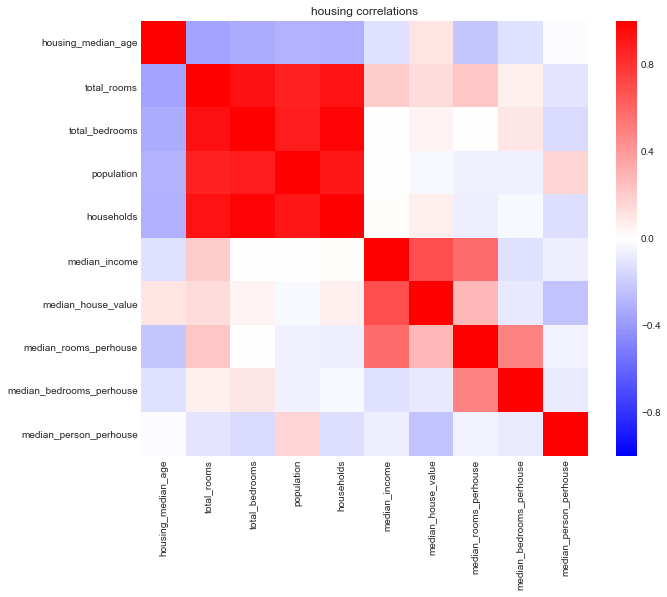

In [256]:
plt.figure( figsize=(10, 8))
plt.title('housing correlations')
_ = sns.heatmap(df_housing.corr().values, vmin=-1., vmax=1., cmap='bwr', 
                xticklabels=list(df_housing.columns),
                yticklabels=list(df_housing.columns))

**_Write HERE your conclusions on the data._**

Encontramos correlaciones elevadas entre las variables 'total_rooms', 'total_bedrooms', 'population' y 'household' superior a 0.82. La información obtenida va a ser redundante entre estas variables y si las eliminamos agilizamos el tiempo en el modelo por lo cual procedemos pues a eliminar las tres primeras variables y comenzar a entrenar el modelo.

In [257]:
df_housing = df_housing.drop('total_rooms', axis=1).drop('total_bedrooms', axis=1).drop('population', axis=1)

### Downsizing the sample

Before building our models, notice that the sample size is possibly too high for laptop computations.
Because of this we are going to retain only 5000 patterns that we select as follows

1. Generate using numpy a permutation of the numerical indices of the sample.
2. Retain the first 5000 indices in the permutation.
3. Form the final sample dataframe with these 5000 indices.

Of these we will retain the last 1000 as a test set and the first 4000 for training and validation purposes.

Notice also that target values are given in dollars so some values are quite high. We thus scale them to, say, thousands of dollars dividing the target variable by 1000 in order to have smaller targets and errors.

In [258]:
#Generamos una permutación de los índices
permutation = np.random.permutation(df_housing.shape[0])
#Nos quedamos con los 5000 primeros índices
muestra = permutation[:5000]
len(muestra)

5000

In [260]:
#Creamos la muestra indexando con los 5000 índices
sample_df = df_housing.iloc[muestra,]
sample_df.head()

,housing_median_age,households,median_income,median_house_value,median_rooms_perhouse,median_bedrooms_perhouse,median_person_perhouse
3178,19.0,607.0,3.0667,75800.0,5.357496,1.011532,3.247117
12252,8.0,1107.0,2.1103,94400.0,4.814815,1.381210,1.935863
17533,43.0,428.0,1.6708,204200.0,3.324766,1.091121,2.366822
13889,8.0,1439.0,2.7138,22500.0,6.931897,1.211258,4.749826
5251,35.0,484.0,7.8426,500001.0,6.708678,1.084711,2.200413


Escalamos la variable *median_house_value*::

In [261]:
sample_df['median_house_value_scale'] = sample_df['median_house_value']/1000

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [262]:
sample_df=sample_df.drop('median_house_value', axis=1)

In [263]:
#Eliminamos casas con precios muy elevados, superiores a 500
sample_df=sample_df[(sample_df.median_house_value_scale < 500)]

In [264]:
sample_df.head()

,housing_median_age,households,median_income,median_rooms_perhouse,median_bedrooms_perhouse,median_person_perhouse,median_house_value_scale
3178,19.0,607.0,3.0667,5.357496,1.011532,3.247117,75.8
12252,8.0,1107.0,2.1103,4.814815,1.381210,1.935863,94.4
17533,43.0,428.0,1.6708,3.324766,1.091121,2.366822,204.2
13889,8.0,1439.0,2.7138,6.931897,1.211258,4.749826,22.5
9827,52.0,444.0,2.5263,5.819820,1.349099,1.779279,286.4


## MLP models

### Building the train and test datasets

Mantenemos 4000 muestras para training y 1000 para test:

In [265]:
train = sample_df[:4000]
test = sample_df[4000:]
print (len(train))
print (len(test))

4000
765


In [266]:
vars     = ['housing_median_age', 'median_bedrooms_perhouse', 'median_rooms_perhouse', 'median_person_perhouse', 'households', 'median_income']
target   = ['median_house_value_scale']  #Nuestro target es ahora éste, tras escalarle.

### MLP architecture

Consider first what could be a reasonable number of layers and of units for a MLP. 
Before starting CV, train individual MLPs likely to overfit mesauring times to get a handle on the tolerance to be used. 

**_Write HERE your analysis and architecture and parameter and solver choices_**

In [267]:
#MLP is sensitive to feature scaling, so it is highly recommended to scale your data
#Estandarizamos el dataset en primer lugar

from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

std_sc = StandardScaler()
xtrain = std_sc.fit_transform( train[ vars ] )
ytrain = train[ 'median_house_value_scale' ]
xtest = std_sc.transform(test[vars])
ytest = test['median_house_value_scale']

In [271]:
from time import time
t0 = time()

#Definimos el número de capas ocultas para proceder a entrenar
hidden_layer_sizes = (15,15)
alpha = 1.e-2 



#solver: lbfgs para problemas pequeños, adam para problemas grandes
mlp_m =  MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, 
                      activation='relu', 
                      solver='lbfgs', alpha=alpha,
                      early_stopping=True,
                      tol=1.e-8, max_iter=10000, verbose=1)


mlp_m.fit(xtrain, ytrain)

t=time()-t0

print("tiempo de cómputo: %.3f segundos" %t)

tiempo de cómputo: 24.575 segundos


In [272]:
#print(mlp_m.coefs_[2].shape)
print(mlp_m.loss_)  #función de coste

1499.90945102


MAE train: 40.332
MAE test: 47.251
R2 train: 0.688
R2 test: 0.572


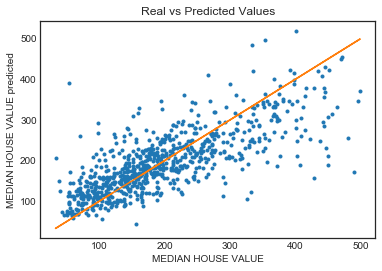

In [273]:
from sklearn.metrics import mean_absolute_error,r2_score

y_pred = mlp_m.predict(xtest)

print("MAE train: %.3f" % mean_absolute_error(ytrain, mlp_m.predict(xtrain)))
print("MAE test: %.3f" % mean_absolute_error(ytest, y_pred))
print("R2 train: %.3f" % r2_score(ytrain, mlp_m.predict(xtrain)))
print("R2 test: %.3f" % r2_score(ytest, y_pred))

plt.title('Real vs Predicted Values')

plt.xlabel('MEDIAN HOUSE VALUE')
plt.ylabel('MEDIAN HOUSE VALUE predicted')
_ = plt.plot(ytest, y_pred, '.', ytest, ytest, '-')

Hemos obtenido un MAE en train de 40.46 frente a 44.7 en test. Además nos hemos calculado los R2 para comprobar que no estabamos haciendo overfitting. Podríamos incluir más capas pero al tener un número tan reducido de muestras tenemos overfitting.

### CV estimation of `alpha`

A reasonable idea is to work with validation sets with more or less the same size than the test set. To do so, use the sklearn `ShuffleSplit` method to work with 5 folds with train-validation splits with sizes 3000-1000.

Decide also on a proper range of $\alpha$ to be explored.

**_Write HERE your CV parameter choices_**

In [274]:
# writhe the code to perform GridSearchCV and to save the CV results in a pkl file 
#            but 
# COMMENT OUT THE GRID SEARCH FIT CALL AND THE PKL FILE SAVING

# use the names of the GridSearchCV object and of the pickle file shown below

from sklearn.model_selection import GridSearchCV, KFold,ShuffleSplit

n_folds = 5

#Vamos a entrenar dejando 3000 para train y 1000 para validación
kf = ShuffleSplit(n_folds, test_size=.25, random_state= 1990)

l_alpha = [10.**k for k in range(-6, 6)]  #Tomamos diferentes alphas entre este rango
param_grid = {'alpha': l_alpha}
hidden_layer_sizes = (15,13)

mlp_m =  MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, 
                      activation='relu', 
                      solver='lbfgs', 
                      early_stopping=True,
                      tol=1.e-8, max_iter=10000)

mlp_alpha_search = GridSearchCV(mlp_m, param_grid=param_grid, cv=kf, 
                                scoring='neg_mean_absolute_error',
                                refit=False,
                                n_jobs=-1, verbose=1)

t_0 = time()
mlp_alpha_search.fit(xtrain, ytrain)
print("\nmlp_grid_search_time: %.3f" %(time() - t_0), "\n\n")
        

f = open('mlp_alpha_search_results.pkl', mode='wb')
pickle.dump(mlp_alpha_search, f)
f.close()


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.3min



mlp_grid_search_time: 221.762 




[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.7min finished


### Analysis of CV results

**_Recover grid search from pickle file and analyze best parameters_**

best_alpha = 1000.000
best_cv_mae = 44.400


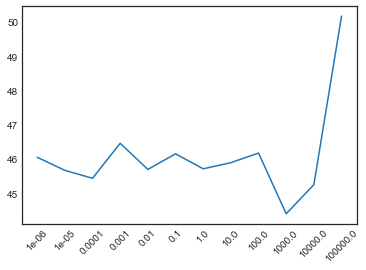

In [275]:
f = open('mlp_alpha_search_results.pkl', mode='rb')
mlp_alpha_search = pickle.load(f)
f.close()

best_alpha = mlp_alpha_search.best_params_['alpha']

print('best_alpha = %.3f' % (best_alpha))
print('best_cv_mae = %.3f' % (-mlp_alpha_search.best_score_))

plt.xticks(range(len(l_alpha)), l_alpha, rotation=45)
_ = plt.plot( -mlp_alpha_search.cv_results_['mean_test_score'])

**_Discuss here the adequacy of your CV results_**

Como podemos observar en la tabla superior, el mejor alpha obtenido es 1000 con el que obtenemos un mean score de 44.48. Alpha es un parámetro para el término de regularización utilizado para combatir el overfitting restringiendo el tamaño de los pesos. El aumento de alpha puede corregir una gran varianza mediante una disminución de los pesos.

### Analysis of Best MLP 

Train and test the best MLP and analyze its errors.

Entrenamos ahora nuestro modelo con el mejor alpha obtenido y calculamos las predicciones para el test. Observamos los errores obtenidos:

In [276]:
from sklearn.model_selection import cross_val_predict
mlp_m_best =  MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, 
                           alpha=best_alpha,
                           activation='relu', 
                           solver='lbfgs', 
                           early_stopping=True,
                           tol=1.e-8, max_iter=10000, verbose=1)


mlp_m_best.fit(xtrain,ytrain)
y_pred_mlp_cv = np.clip( cross_val_predict(mlp_m_best, xtest, ytest, cv=5), 5., 500.)
print("MAE test: %.3f" % mean_absolute_error(ytest, y_pred_mlp_cv))


MAE test: 47.438


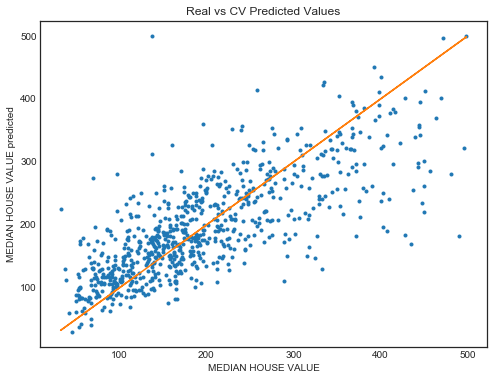

In [277]:
plt.figure( figsize=(8,6))

plt.title('Real vs CV Predicted Values')
plt.xlabel('MEDIAN HOUSE VALUE')
plt.ylabel('MEDIAN HOUSE VALUE predicted')
_ = plt.plot(ytest, y_pred_mlp_cv, '.', ytest, ytest, '-')

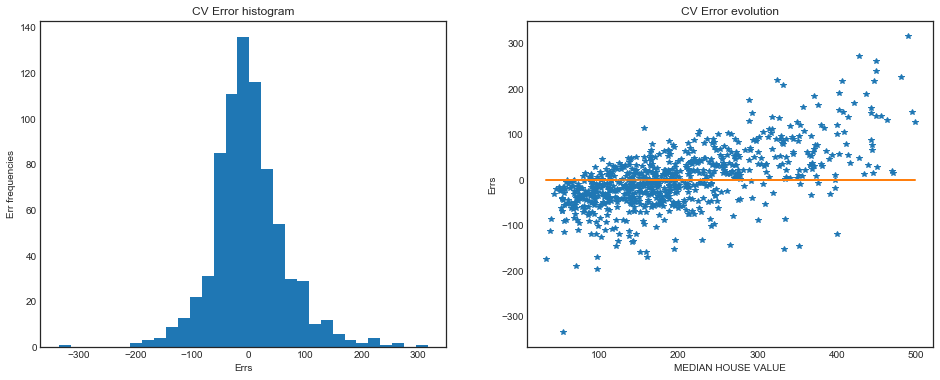

In [278]:
err = ytest - y_pred

plt.figure( figsize=(16,6))

plt.subplot(1,2,1)
plt.title("CV Error histogram")
plt.xlabel("Errs")
plt.ylabel("Err frequencies")
_ = plt.hist(err, bins=31)

plt.subplot(1,2,2)
plt.title("CV Error evolution")
plt.xlabel("MEDIAN HOUSE VALUE")
plt.ylabel("Errs")
_ = plt.plot(ytest, err, '*', ytest, 0.*ytest, '-')

plt.show()

**_Discuss here your conclusions about the MLPs you have obtained_**

En primer lugar, hemos visto que introducir más capas a nuestro perceptrón es una de las soluciones para reducir el MAE pero esto solo es posible si tenemos una mayor cantidad de datos disponibles para entrenar ya que sino llevaremos a nuestro modelo a producir overfitting. 
También observamos como se distribuyen los errores. Vemos que no sigue una distribución normal y de hecho encontramos algunos valores en los extremos. En el gráfico de residuos de la derecha observamos que no presenta homocedasticidad teniendo errores a la alta en las casas caras y errores a la baja en las casas más baratas.

## Support Vector Regression

### Building the train and test datasets

In [197]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR

#Estandarizamos el dataset
mm_sc = MinMaxScaler((0, 1))

n_patterns, dim = xtrain.shape

xtrain = mm_sc.fit_transform( train[ vars ] )
ytrain = train[ 'median_house_value_scale' ]
xtest = mm_sc.transform(test[vars])
ytest = test['median_house_value_scale']

### SVR training times

We are going to work with a Gaussian SVR model, which may take time to train.
Before starting CV, train individual SVRs likely to overfit mesauring times to get a handle on the times involved.

MAE train: 70.179
MAE test: 70.968
num_svs:  3637
num SVs at bound:  3635


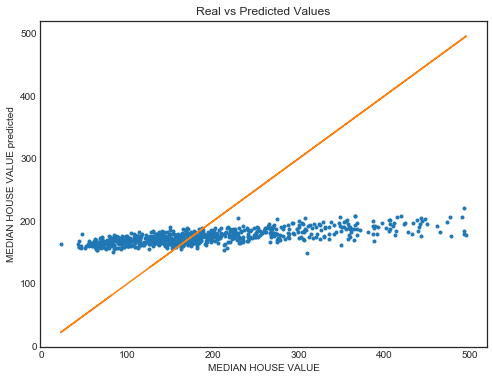

In [198]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

#SVR hyperparams
C = 1.
dim = xtrain.shape[1]
gamma = 1./dim
epsilon = ytrain.std()/10.

svr_m =  SVR(kernel='rbf', C=C, gamma=gamma, epsilon=epsilon)

svr_m.fit(xtrain, ytrain)
#print (svr_m.score(xtrain,ytrain))
y_pred = svr_m.predict(xtest)

print("MAE train: %.3f" % mean_absolute_error(ytrain, svr_m.predict(xtrain)))
print("MAE test: %.3f" % mean_absolute_error(ytest, y_pred))
print("num_svs: ", svr_m.support_vectors_.shape[0])
print("num SVs at bound: ", (abs(svr_m.dual_coef_) == C).sum())

plt.figure( figsize=(8,6))
plt.title('Real vs Predicted Values')
plt.xlabel('MEDIAN HOUSE VALUE')
plt.ylabel('MEDIAN HOUSE VALUE predicted')
_ = plt.plot(ytest, y_pred, '.', ytest,ytest, '-')

Claramente está haciendo underfitting. Ajustamos mejor los hiperparámetros:

MAE train: 42.956
MAE test: 45.242
num_svs:  3863
num SVs at bound:  3821


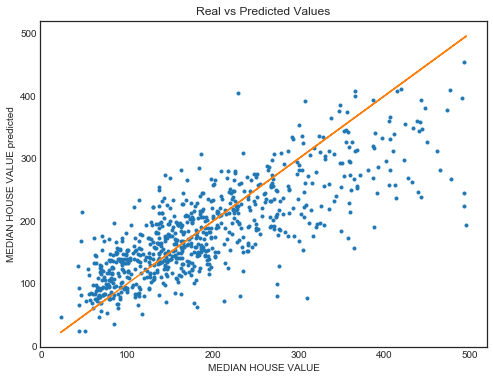

In [199]:
C = 100.
gamma = 16./dim
epsilon = ytrain.std()/50.

svr_m =  SVR(kernel='rbf', C=C, gamma=gamma, epsilon=epsilon)

svr_m.fit(xtrain, ytrain)
# print (svr_m.score(xtrain,ytrain))
y_pred = svr_m.predict(xtest)


print("MAE train: %.3f" % mean_absolute_error(ytrain, svr_m.predict(xtrain)))
print("MAE test: %.3f" % mean_absolute_error(ytest, y_pred))
print("num_svs: ", svr_m.support_vectors_.shape[0])
print("num SVs at bound: ", (abs(svr_m.dual_coef_) == C).sum())

plt.figure( figsize=(8,6))
plt.title('Real vs Predicted Values')
plt.xlabel('MEDIAN HOUSE VALUE')
plt.ylabel('MEDIAN HOUSE VALUE predicted')
_ = plt.plot(ytest, y_pred, '.', ytest,ytest, '-')

##### CV estimation of `C`, `gamma`, `epsilon`

A reasonable idea is to work with validation sets with more or less the same size than the test set. 
Use again the sklearn `ShuffleSplit` method to work with 5 folds with train-validation splits with sizes 3000-1000.

Decide also on the proper ranges of  `C`, `gamma`, `epsilon` to be explored.

**_Write HERE your CV parameter choices_**

In [208]:
# writhe the code to perform GridSearchCV and to save the CV results in a pkl file 
#            but 
# COMMENT OUT THE GRID SEARCH FIT CALL AND THE PKL FILE SAVING

# use the names of the GridSearchCV object and of the pickle file shown below


t_0 = time()
n_folds = 5
kf = ShuffleSplit(n_folds, test_size=.25, random_state=0)

# SVR hyperpars
svr_m = SVR(kernel='rbf', shrinking=True, tol=1.e-3, cache_size= 1000)
        
l_gamma   = [10.**k for k in range(-5, 4)] 
l_C       = [10.**k for k in range(-3, 4)] 
l_epsilon = list( ytrain.std() * np.array([2.**k for k in range(-5, 0)]) )


param_grid = {'C': l_C, 'gamma':l_gamma, 'epsilon':l_epsilon}
scoring="neg_mean_absolute_error"
n_jobs=-1

C_gamma_epsilon_search = GridSearchCV(svr_m, param_grid=param_grid, 
                                      cv=kf, scoring=scoring, 
                                      n_jobs=n_jobs, 
                                      return_train_score=True,
                                      verbose=True)


C_gamma_epsilon_search.fit(xtrain, ytrain)
print("GrdidSearchCV_time: %.2f segundos" % (time() - t_0))

f_pkl = open("svr_C_gamma_epsilon_cv_search_results.pkl", 'wb') 
pickle.dump(C_gamma_epsilon_search, f_pkl)
f_pkl.close()

Fitting 5 folds for each of 315 candidates, totalling 1575 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 1575 out of 1575 | elapsed: 10.4min finished


GrdidSearchCV_time: 625.44 segundos


### Analysis of CV results

**_Recover grid search from pickle file and analyze best parameters_**

In [209]:
#Abrimos los resultados guardados en el archivo

f_pkl = open('svr_C_gamma_epsilon_cv_search_results.pkl', mode='rb')
C_gamma_epsilon_search = pickle.load(f_pkl)
f_pkl.close()

Ordenamos por el mejor score en CV:

In [224]:
df_C_gamma_epsilon_search = pd.DataFrame.from_dict(C_gamma_epsilon_search.cv_results_)

df_C_gamma_epsilon_search.sort_values(by='mean_test_score', ascending=False)[['param_C', 'param_gamma', \
                                                                              'param_epsilon', 'mean_test_score']][ : 10]


,param_C,param_gamma,param_epsilon,mean_test_score
240,100,10,6.02695,-42.659016
231,100,10,3.01348,-42.669958
249,100,10,12.0539,-42.699074
294,1000,10,12.0539,-42.735598
258,100,10,24.1078,-42.764584
303,1000,10,24.1078,-42.779129
285,1000,10,6.02695,-42.785387
276,1000,10,3.01348,-42.794013
312,1000,10,48.2156,-43.589907
267,100,10,48.2156,-43.646056


best_C: 100.0 	best_gamma: 10.0 	best_epsilon: 6.02695009474
best_cv_mae = 42.659


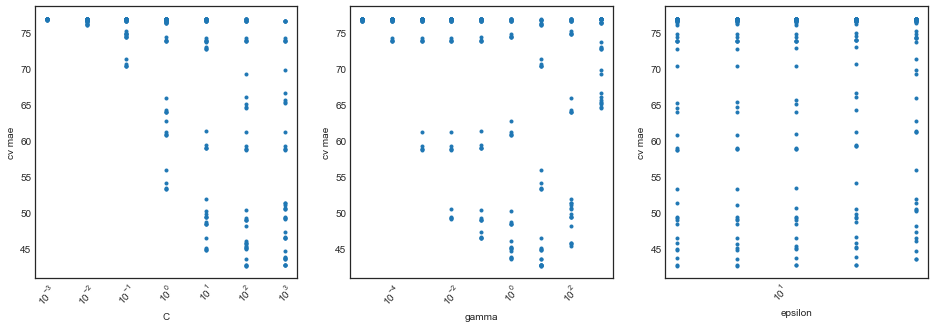

In [228]:
#Dibujamos los hiperparámetros

plt.figure( figsize=(16, 5))

print("best_C:", C_gamma_epsilon_search.best_params_['C'], "\tbest_gamma:", C_gamma_epsilon_search.best_params_['gamma'],"\tbest_epsilon:",C_gamma_epsilon_search.best_params_['epsilon'])
print('best_cv_mae = %.3f' % (-C_gamma_epsilon_search.best_score_))

plt.subplot(1, 3, 1)
plt.xticks(range(len(l_C)), np.round(l_C, 2), rotation=45)
plt.xlabel('C')
plt.ylabel('cv mae')
plt.xscale('log')
_ = plt.plot( df_C_gamma_epsilon_search['param_C'], -df_C_gamma_epsilon_search['mean_test_score'], '.')

plt.subplot(1, 3, 2)
plt.xticks(range(len(l_gamma)), np.round(np.array(l_gamma)*dim, 2), rotation=45)
plt.xlabel('gamma')
plt.ylabel('cv mae')
plt.xscale('log')
_ = plt.plot( df_C_gamma_epsilon_search['param_gamma'], -df_C_gamma_epsilon_search['mean_test_score'], '.')

plt.subplot(1, 3, 3)
plt.xticks(range(len(l_epsilon)), np.round(np.array(l_epsilon)/ytrain.std(), 3), rotation=45)
plt.xlabel('epsilon')
plt.ylabel('cv mae')
plt.xscale('log')
_ = plt.plot( df_C_gamma_epsilon_search['param_epsilon'], -df_C_gamma_epsilon_search['mean_test_score'], '.')

plt.show()

**_Discuss here the adequacy of your CV results_**

Los mejores valores obtenidos para cada parámetro con los que obtenemos el mejor score en cross validation, es decir, en validación (no en train) con un 42.659 son:  

C: 100  
gamma: 10  
epsilon: 6.02

### Analysis of Best SVR

Train and test the best SVR and analyze its errors.

C: 100.00	gamma: 10.00	epsilon: 6.0270
mae_mean: 42.769	mae_std: 0.31
MAE test: 45.930


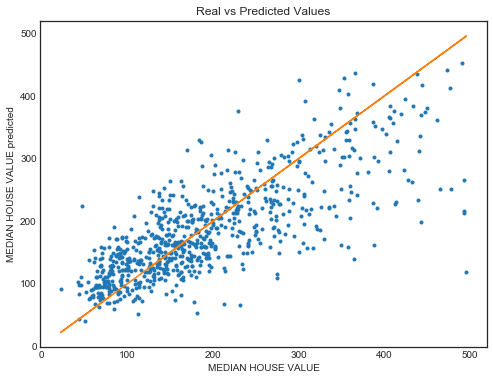

In [236]:
from sklearn.model_selection import cross_val_score, cross_val_predict

best_C       = C_gamma_epsilon_search.best_params_['C']
best_gamma   = C_gamma_epsilon_search.best_params_['gamma']
best_epsilon = C_gamma_epsilon_search.best_params_['epsilon']

print('C: %.2f\tgamma: %.2f\tepsilon: %.4f' %  (best_C, best_gamma, best_epsilon))

svr_m_best =  SVR(C=best_C, gamma=best_gamma, epsilon=best_epsilon,
             kernel='rbf', shrinking=True, 
             tol=1.e-3, cache_size= 1000)

n_folds = 5
kf = KFold(n_folds, shuffle=True)

svr_m_best.fit(xtrain, ytrain)

scores = cross_val_score(svr_m_best, xtrain, ytrain, scoring="neg_mean_absolute_error", cv=kf, n_jobs=-1)
print("mae_mean: %.3f\tmae_std: %.2f" % (-scores.mean(), scores.std()))


y_pred = np.clip( cross_val_predict(svr_m_best, xtest, ytest, cv=kf, n_jobs=-1), 5., 500.)
print("MAE test: %.3f" % mean_absolute_error(ytest, y_pred))


plt.figure( figsize=(8,6))
plt.title('Real vs Predicted Values')
plt.xlabel('MEDIAN HOUSE VALUE')
plt.ylabel('MEDIAN HOUSE VALUE predicted')
_ = plt.plot(ytest, y_pred, '.', ytest, ytest, '-')

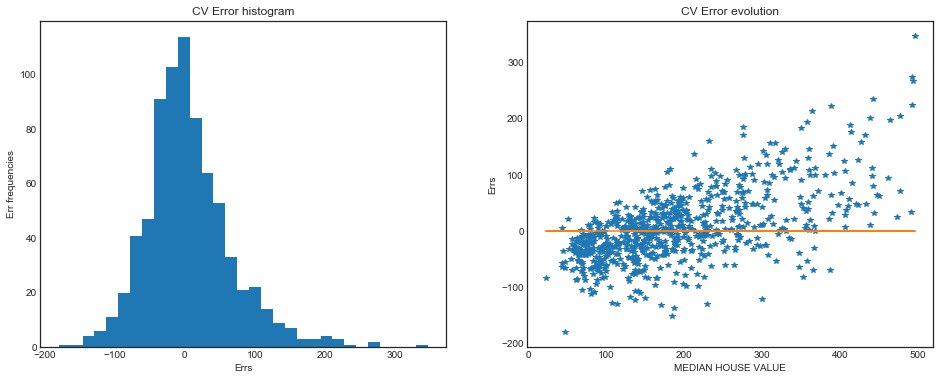

In [233]:
err = ytest - y_pred

plt.figure( figsize=(16,6))

plt.subplot(1,2,1)
plt.title("CV Error histogram")
plt.xlabel("Errs")
plt.ylabel("Err frequencies")
_ = plt.hist(err, bins=31)

plt.subplot(1,2,2)
plt.title("CV Error evolution")
plt.xlabel("MEDIAN HOUSE VALUE")
plt.ylabel("Errs")
_ = plt.plot(ytest, err, '*', ytest, 0.*ytest, '-')

plt.show()

Como observamos los errores no siguen una distribución normal y presentan asimetría.
En el gráfico de la derecha observamos que presenta heterocedasticidad tendiendo a predecir a la alta en aquellas casas con valor elevado y a la baja en aquellas con valor bajo.  

## Final conclusions

**_write here your ideas/conclusions_**

* Overall impresions onyour models
* Which one is best and why?
* Any ideas on how to improve them?

Resumimos en la siguiente tabla los resultados obtenidos tras ajustar cada modelo con su correspondiente grid:

|     MAE    |     MLR    |     SVR    |
| ---------- | ---------- | ---------- |
|   Train    |   44.400   |   42.769   |
|    Test    |   47.438   |   45.930   |
| ---------- | ---------- | ---------- |


En primer lugar, los MAE obtenidos rondan entre 40 y 50. Esto es así porque escalamos la variable target en el preprocesado dividiéndola por 1000. Por tanto realmente estaríamos hablando de un MAE de 40000-50000 aproximadamente lo cual tiene sentido con los precios de las viviendas con los que estamos trabajando.
Ambos modelos presentan MAE similares aunque obtenemos una considerable mejoría en el modelo de máquinas vector soporte reduciendo ese MAE a casi 45 en test.  
Para mejorar los modelos, en particular el modelo MLP de regresión, una solución sería incluir más capas en nuestra red neuronal, lo cual mejoraría los resultados notablemente. El problema que nos encontraríamos en este supuesto es que el modelo incurrirá en overfitting si no disponemos de una mayor muestra de datos por lo que habría que buscar una combinación entre aumentar el número de datos y el número de capas.
